In [48]:
import pandas as pd
import numpy as np
import plotly.express as px
%matplotlib inline
from pdpbox import pdp, info_plots
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from category_encoders import OneHotEncoder
df = pd.read_csv("/Users/marnielayton/MyGA-repo/Homework/Unit3/insurance_premiums.csv")
np.warnings.filterwarnings('ignore', message='is_categorical is deprecated')

In [49]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [50]:
#shuffle data set
df = df.sample(frac=1.0)

In [51]:
#creates cutoff point between train and test set, 80% in train
cutoff = int(df.shape[0]*.8)

In [52]:
#splits train and test set
train, test = df[:cutoff].copy(), df[cutoff:].copy()

In [53]:
y_train = train['charges']
X_train = train.iloc[:, :6]

y_test  = test['charges']
X_tet   = test.iloc[:, :6]

In [54]:
# create a validation set, 80% in train, 20% in val
val_cutoff = int(train.shape[0]*.8)

train, val = train[:val_cutoff].copy(), train[val_cutoff:].copy()

In [55]:
y_train = train['charges']
X_train = train.iloc[:, :6]

y_val   = val['charges']
X_val   = val.iloc[:, :6]

In [56]:
#use onehotencoder since all categorical 
encoder = OneHotEncoder(use_cat_names=True)

In [57]:
#fit_transform the training set
encoder.fit_transform(X_train)

,age,sex_male,sex_female,bmi,children,smoker_yes,smoker_no,region_southeast,region_northeast,region_northwest,region_southwest
1300,45,1,0,30.360,0,1,0,1,0,0,0
529,18,1,0,25.460,0,0,1,0,1,0,0
371,57,0,1,22.230,0,0,1,0,1,0,0
839,59,0,1,31.350,0,0,1,0,0,1,0
15,19,1,0,24.600,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
136,19,1,0,34.100,0,0,1,0,0,0,1
668,62,1,0,32.015,0,1,0,0,1,0,0
205,28,0,1,28.880,1,0,1,0,1,0,0
474,54,1,0,25.100,3,1,0,0,0,0,1


In [58]:
#transform the val set
encoder.transform(X_val)

,age,sex_male,sex_female,bmi,children,smoker_yes,smoker_no,region_southeast,region_northeast,region_northwest,region_southwest
21,30,0,1,32.400,1,0,1,0,0,0,1
1135,50,0,1,28.120,3,0,1,0,0,1,0
131,61,0,1,22.040,0,0,1,0,1,0,0
901,60,1,0,40.920,0,1,0,1,0,0,0
35,19,1,0,20.425,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
697,41,1,0,35.750,1,1,0,1,0,0,0
495,20,1,0,27.930,0,0,1,0,1,0,0
954,34,1,0,27.835,1,1,0,0,0,1,0
971,34,0,1,23.560,0,0,1,0,1,0,0


In [59]:
mod = GradientBoostingRegressor()
pipe = make_pipeline(encoder, mod)

In [60]:
#fit the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sex', 'smoker', 'region'],
                               use_cat_names=True)),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [61]:
#score the model
pipe.score(X_val, y_val)

0.8906482734546768

In [62]:
# setup our model -- using the onehot encoder -- makes these things a *little* easier to render
pipe = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                     GradientBoostingRegressor())
# and fit
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sex', 'smoker', 'region'],
                               use_cat_names=True)),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [63]:
transformed_X = pipe[0].transform(X_train)

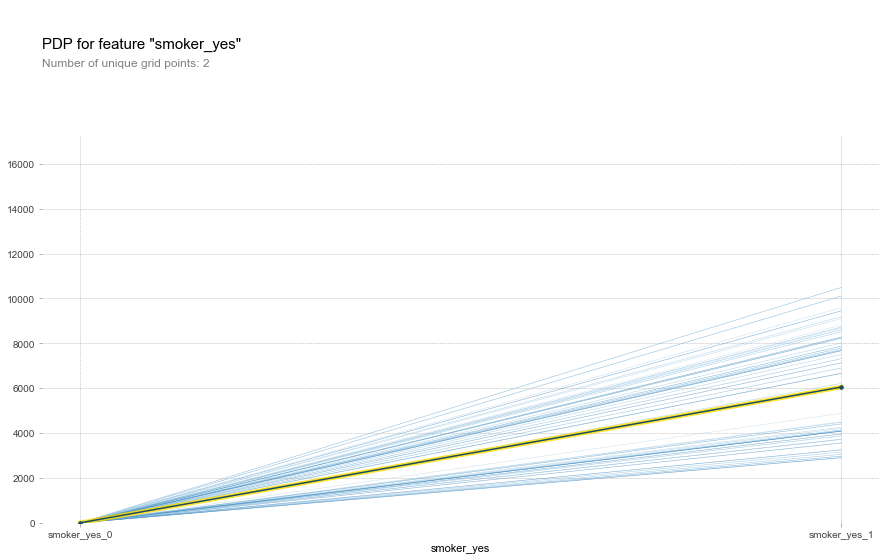

In [64]:
# what was the additive impact of EACH unique value of OverallQual?  What was its marginal impact?
pdp_smoker_yes = pdp.pdp_isolate(
    model=pipe[1], dataset=transformed_X, model_features=transformed_X.columns.tolist(), 
    feature='smoker_yes', cust_grid_points = transformed_X['smoker_yes'].unique().tolist()
)

fig, axes = pdp.pdp_plot(pdp_smoker_yes, 'smoker_yes', plot_lines=True, frac_to_plot=50)

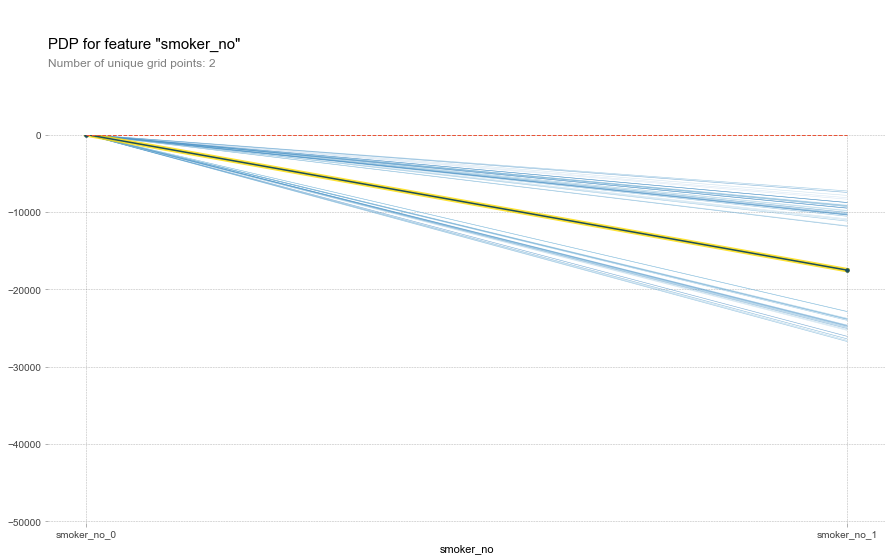

In [65]:
# what was the additive impact of EACH unique value of OverallQual?  What was its marginal impact?
pdp_smoker_no = pdp.pdp_isolate(
    model=pipe[1], dataset=transformed_X, model_features=transformed_X.columns.tolist(), 
    feature='smoker_no', cust_grid_points = transformed_X['smoker_no'].unique().tolist()
)

fig, axes = pdp.pdp_plot(pdp_smoker_no, 'smoker_no', plot_lines=True, frac_to_plot=50)

In [66]:
#plots show that smoking status affects the charges, the difference between being a smoker

In [67]:
#scatter plot to show effect of bmi on charges
px.scatter(df, x='bmi', y='charges', trendline='ols',title='BMI by Charges')

In [68]:
#created new BMI column split on underweight, normal weight, overweight, and obese. Didn't think it would have much of an effect but tried anyway.
conditions = [
    df['bmi']<18.5, 
    df['bmi'].between(18.5,24.9),
    df['bmi'].between(24.91,29.9),
    df['bmi']>=29.9
]
results = [
    '0',
    '1',
    '2',
    '3'
]

df['bmi_status'] = np.select(conditions, results, -1)

In [69]:
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_status
1300,45,male,30.36,0,yes,southeast,62592.87309,3
529,18,male,25.46,0,no,northeast,1708.00140,2
371,57,female,22.23,0,no,northeast,12029.28670,1
839,59,female,31.35,0,no,northwest,12622.17950,3
15,19,male,24.60,1,no,southwest,1837.23700,1


In [70]:
y_train = train['charges']
X_train = train.iloc[:, :6]

y_val   = val['charges']
X_val   = val.iloc[:, :6]

In [71]:
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_status
1300,45,male,30.36,0,yes,southeast,62592.87309,3
529,18,male,25.46,0,no,northeast,1708.00140,2
371,57,female,22.23,0,no,northeast,12029.28670,1
839,59,female,31.35,0,no,northwest,12622.17950,3
15,19,male,24.60,1,no,southwest,1837.23700,1


In [72]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sex', 'smoker', 'region'],
                               use_cat_names=True)),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [74]:
pipe.score(X_val, y_val)
#score did not change with addition of new column

0.8903362140761208

In [75]:
#determine which column affected charges the most
pd.DataFrame({
    'Col': pipe[0].get_feature_names(),
    'Importance': pipe[1].feature_importances_
})
#results shows that smoking and BMI both affect the charges, however not smoking has the largest effect

,Col,Importance
0,age,0.113023
1,sex_male,0.000192
2,sex_female,0.000178
3,bmi,0.190576
4,children,0.011492
5,smoker_yes,0.392658
6,smoker_no,0.284968
7,region_southeast,0.000114
8,region_northeast,0.001810
9,region_northwest,0.003453


In [76]:
#find the best model parameters
n_estimators  = [50, 100, 200, 300]
learning_rate = [.05, .1, .2]
max_depth     = [3, 4, 5]
cv_scores     = []
# and cycle through our model parameters
for estimators in n_estimators:
    for rate in learning_rate:
        for depth in max_depth:
            print(f"Fitting model with parameters:  n_estimators - {estimators}, learning_rate - {rate}, max_depth - {depth}")
            mod   = GradientBoostingRegressor(n_estimators=estimators, learning_rate=rate, max_depth=depth, max_features=0.6)
            pipe  = make_pipeline(ce.TargetEncoder(), mod)
            pipe.fit(X_train, y_train)
            score = pipe.score(X_val, y_val)
            print(f"Out-of-sample score: {score}")
            cv_scores.append((score, estimators, rate, depth))

Fitting model with parameters:  n_estimators - 50, learning_rate - 0.05, max_depth - 3
Out-of-sample score: 0.8816504248255116
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.05, max_depth - 4
Out-of-sample score: 0.8861848288750687
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.05, max_depth - 5
Out-of-sample score: 0.8864386252193608
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.1, max_depth - 3
Out-of-sample score: 0.8964279181166037
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.1, max_depth - 4
Out-of-sample score: 0.8938075912771961
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.1, max_depth - 5
Out-of-sample score: 0.8885529535186589
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.2, max_depth - 3
Out-of-sample score: 0.8868277524272807
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.2, max_depth - 4
Out-of-sample score: 0.877716

In [77]:
#shows the best model parameters
max(cv_scores)

(0.9010287138816251, 100, 0.05, 3)

In [79]:
#update the model to include the best model parameters
mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=3)

In [80]:
#reset df to remove validation set
df = df.sample(frac=1.0)
cutoff = int(df.shape[0]*.8)
train, test = df[:cutoff].copy(), df[cutoff:].copy()

In [81]:
#reset train and test
X_train, y_train = train.drop('charges', axis=1),train['charges']
X_test, y_test = test.drop('charges', axis=1),test['charges']

In [82]:
#create pipe
pipe = make_pipeline(encoder,mod)

In [83]:
#fit the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sex', 'smoker', 'region'],
                               use_cat_names=True)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05))])

In [84]:
#score on test set
pipe.score(X_test, y_test)

0.8977947175146581